# Optical Character Recognition (OCR) with OpenVINO™

This tutorial demonstrates how to perform optical character recognition (OCR) with OpenVINO models. It is a continuation of the [hello-detection](../hello-detection/hello-detection.ipynb) tutorial, which shows only text detection.

The [horizontal-text-detection-0001](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/intel/horizontal-text-detection-0001/README.md) and [text-recognition-resnet](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/text-recognition-resnet-fc/README.md) models are used together for text detection and then text recognition.

In this tutorial, Open Model Zoo tools including Model Downloader, Model Converter and Info Dumper are used to download and convert the models from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo). For more information, refer to the [model-tools](../model-tools/model-tools.ipynb) tutorial.


#### Table of contents:

- [Imports](#Imports)
- [Settings](#Settings)
- [Download Models](#Download-Models)
- [Convert Models](#Convert-Models)
- [Select inference device](#Select-inference-device)
- [Object Detection](#Object-Detection)
    - [Load a Detection Model](#Load-a-Detection-Model)
    - [Load an Image](#Load-an-Image)
    - [Do Inference](#Do-Inference)
    - [Get Detection Results](#Get-Detection-Results)
- [Text Recognition](#Text-Recognition)
    - [Load Text Recognition Model](#Load-Text-Recognition-Model)
    - [Do Inference](#Do-Inference)
- [Show Results](#Show-Results)
    - [Show Detected Text Boxes and OCR Results for the Image](#Show-Detected-Text-Boxes-and-OCR-Results-for-the-Image)
    - [Show the OCR Result per Bounding Box](#Show-the-OCR-Result-per-Bounding-Box)
    - [Print Annotations in Plain Text Format](#Print-Annotations-in-Plain-Text-Format)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/optical-character-recognition/optical-character-recognition.ipynb" />


installation for front end and back end

In [132]:
!pip install gradio
from typing import Callable, Literal
import gradio as gr
!pip install pytesseract
!pip install pdf2image
!pip install pytesseract pdf2image pillow gradio

In [133]:
import platform
# Install openvino-dev package
%pip install -q "openvino-dev>=2024.0.0"  "onnx<1.16.2" torch torchvision pillow opencv-python --extra-index-url https://download.pytorch.org/whl/cpu

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

## Imports
[back to top ⬆️](#Table-of-contents:)


In [134]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
from IPython.display import Markdown, display
from PIL import Image

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)
from notebook_utils import load_image, device_widget, download_file

## Settings
[back to top ⬆️](#Table-of-contents:)


In [135]:
core = ov.Core()

model_dir = Path("model")
precision = "FP16"
detection_model = "horizontal-text-detection-0001"
recognition_model = "text-recognition-resnet-fc"

model_dir.mkdir(exist_ok=True)

## Download Models
[back to top ⬆️](#Table-of-contents:)

The next cells will run Model Downloader to download the detection and recognition models. If the models have been downloaded before, they will not be downloaded again.

In [136]:
download_command = (
    f"omz_downloader --name {detection_model},{recognition_model} --output_dir {model_dir} --cache_dir {model_dir} --precision {precision}  --num_attempts 5"
)
display(Markdown(f"Download command: `{download_command}`"))
display(Markdown(f"Downloading {detection_model}, {recognition_model}..."))
!$download_command
display(Markdown(f"Finished downloading {detection_model}, {recognition_model}."))

detection_model_path = (model_dir / "intel/horizontal-text-detection-0001" / precision / detection_model).with_suffix(".xml")
recognition_model_path = (model_dir / "public/text-recognition-resnet-fc" / precision / recognition_model).with_suffix(".xml")

Download command: `omz_downloader --name horizontal-text-detection-0001,text-recognition-resnet-fc --output_dir model --cache_dir model --precision FP16  --num_attempts 5`

Downloading horizontal-text-detection-0001, text-recognition-resnet-fc...

################|| Downloading horizontal-text-detection-0001 ||################

========== Retrieving model/intel/horizontal-text-detection-0001/FP16/horizontal-text-detection-0001.xml from the cache

========== Retrieving model/intel/horizontal-text-detection-0001/FP16/horizontal-text-detection-0001.bin from the cache

################|| Downloading text-recognition-resnet-fc ||################

========== Retrieving model/public/text-recognition-resnet-fc/vedastr/models/__init__.py from the cache

========== Retrieving model/public/text-recognition-resnet-fc/vedastr/models/builder.py from the cache

========== Retrieving model/public/text-recognition-resnet-fc/vedastr/models/model.py from the cache

========== Retrieving model/public/text-recognition-resnet-fc/vedastr/models/weight_init.py from the cache

========== Retrieving model/public/text-recognition-resnet-fc/vedastr/models/registry.py from the cache

========== Retrieving model/public/text-recognition-resnet-fc/vedastr/mode

Finished downloading horizontal-text-detection-0001, text-recognition-resnet-fc.

In [ ]:
### The text-recognition-resnet-fc model consists of many files. All filenames are printed in
### the output of Model Downloader. Uncomment the next two lines to show this output.

# for line in download_result:
#    print(line)

## Convert Models
[back to top ⬆️](#Table-of-contents:)

The downloaded detection model is an Intel model, which is already in OpenVINO Intermediate Representation (OpenVINO IR) format. The text recognition model is a public model which needs to be converted to OpenVINO IR. Since this model was downloaded from Open Model Zoo, use Model Converter to convert the model to OpenVINO IR format.

The output of Model Converter will be displayed. When the conversion is successful, the last lines of output will include `[ SUCCESS ] Generated IR version 11 model.`

In [137]:
convert_command = f"omz_converter --name {recognition_model} --precisions {precision} --download_dir {model_dir} --output_dir {model_dir}"
display(Markdown(f"Convert command: `{convert_command}`"))
display(Markdown(f"Converting {recognition_model}..."))
! $convert_command

Convert command: `omz_converter --name text-recognition-resnet-fc --precisions FP16 --download_dir model --output_dir model`

Converting text-recognition-resnet-fc...

========== Converting text-recognition-resnet-fc to ONNX
Conversion to ONNX command: /usr/bin/python3 -- /usr/local/lib/python3.10/dist-packages/omz_tools/internal_scripts/pytorch_to_onnx.py --model-path=/usr/local/lib/python3.10/dist-packages/omz_tools/models/public/text-recognition-resnet-fc --model-path=model/public/text-recognition-resnet-fc --model-name=get_model --import-module=model '--model-param=file_config=r"model/public/text-recognition-resnet-fc/vedastr/configs/resnet_fc.py"' '--model-param=weights=r"model/public/text-recognition-resnet-fc/vedastr/ckpt/resnet_fc.pth"' --input-shape=1,1,32,100 --input-names=input --output-names=output --output-file=model/public/text-recognition-resnet-fc/resnet_fc.onnx

/usr/local/lib/python3.10/dist-packages/omz_tools/models/public/text-recognition-resnet-fc/model.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construc

**Start app**


In [179]:
import gradio as gr
import os

# Function to handle the "make me something" input and sliders
def handle_submission(chat_input, calorie_input, thrill_slider, salt_slider, sugar_slider, image_upload):
    # Format the data into a string
    data = f"""
    Request: {chat_input}
    Calories: {calorie_input if calorie_input else "Not provided"}
    Thrill Slider: {thrill_slider}
    Salt Slider: {salt_slider}
    Sugar Slider: {sugar_slider}
    Image Uploaded: {'Yes' if image_upload else 'No'}
    """

    # Save the data to a text file in the local project directory
    with open("submission_data.txt", "a") as file:
        file.write(data)
        file.write("\n" + "-"*50 + "\n")  # Add a separator between entries

    # Save the uploaded image if it exists
    if image_upload:
        image_upload.save("uploaded_image.png")  # Save image as 'uploaded_image.png'

    return "Data has been saved successfully!"

# Function to enable/disable sliders based on "make me something" input
def toggle_fields(chat_input):
    # Enable sliders if there's any input in the chat field
    if chat_input:
        return gr.update(interactive=True), gr.update(interactive=True), gr.update(interactive=True)
    else:
        return gr.update(interactive=False), gr.update(interactive=False), gr.update(interactive=False)

# Function to enable/disable submit button
def toggle_submit(chat_input, image_upload):
    return gr.update(interactive=bool(chat_input) or image_upload is not None)

# Create interface
with gr.Blocks() as demo:

    # Title
    gr.Markdown("# Make Me Something Bot")

    # Chat input field
    chat_input = gr.Textbox(label="Make me something", placeholder="Enter a request for the chatbot...", lines=3)

    # Image upload field
    image_upload = gr.Image(label="Upload an image", type="pil")

    # Calorie input and toggle
    calorie_toggle = gr.Checkbox(label="Enable calorie input")
    calorie_input = gr.Number(label="Daily Calories", visible=False)

    def toggle_calorie_field(enable_calorie):
        return gr.update(visible=enable_calorie)

    # Connect calorie toggle to visibility of calorie input
    calorie_toggle.change(toggle_calorie_field, inputs=calorie_toggle, outputs=calorie_input)

    # Sliders toggles
    slider_toggle = gr.Checkbox(label="Enable sliders")

    # Health sliders
    thrill_slider = gr.Slider(minimum=0.03, maximum=1, step=0.01, value=0.5, label="How healthy do you want to be?", interactive=False)
    salt_slider = gr.Slider(minimum=0.03, maximum=1, step=0.01, value=0.5, label="Salt Level", interactive=False)
    sugar_slider = gr.Slider(minimum=0.03, maximum=1, step=0.01, value=0.5, label="Sugar Level", interactive=False)

    # Define custom labels for the extreme sides
    gr.Markdown("### Health Slider: Thrill Seeker (Right) to Live to 100 (Left)")
    gr.Markdown("### Salt Slider: The Ocean (Right) to Heart Smart (Left)")
    gr.Markdown("### Sugar Slider: Sugary (Right) to Minimal Sugar (Left)")

    # Disable sliders unless "make me something" field is filled
    chat_input.change(toggle_fields, inputs=chat_input, outputs=[thrill_slider, salt_slider, sugar_slider])

    # Submit button
    submit_button = gr.Button("Submit", interactive=False)

    # Enable/disable submit button based on conditions
    chat_input.change(toggle_submit, inputs=[chat_input, image_upload], outputs=submit_button)
    image_upload.change(toggle_submit, inputs=[chat_input, image_upload], outputs=submit_button)

    # Message to confirm data saving
    output_text = gr.Textbox(label="Status", interactive=False)

    # Submit action, save data to file and show status message
    submit_button.click(handle_submission, inputs=[chat_input, calorie_input, thrill_slider, salt_slider, sugar_slider, image_upload], outputs=output_text)

# Launch the app
demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e93cda64e86bc7b1b0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [180]:
device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

## Object Detection
[back to top ⬆️](#Table-of-contents:)

Load a detection model, load an image, do inference and get the detection inference result.

### Load a Detection Model
[back to top ⬆️](#Table-of-contents:)


In [140]:
detection_model = core.read_model(model=detection_model_path, weights=detection_model_path.with_suffix(".bin"))
detection_compiled_model = core.compile_model(model=detection_model, device_name=device.value)

detection_input_layer = detection_compiled_model.input(0)

### Load an Image
[back to top ⬆️](#Table-of-contents:)


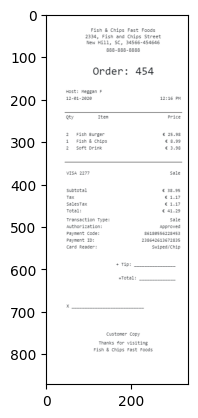

In [181]:
# The `image_file` variable can point to a URL or a local image.

#most_recent = ""
#using url:
# example url: "https://www.thecookierookie.com/wp-content/uploads/2020/03/Grocery-List-JPG.jpg"
#image_file = download_file("", directory="data")
#image_file = download_file(my_global_var)
#image_filename = download_file(
 #  "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/tower.jpg",
#    directory="data")
#my_global_var = "/content/uploaded_files/fast-food-restaurant-template-with-itemized-food-and-tax.png"
#image = cv2.imread(str(image_file))
# /content/uploaded_files/part-of-the-ingredients-list-from-a-package-of-cupcakes-many-of-the-BP3MP7.jpg
#ret = "/content/uploaded_files/" + uploaded_files[-1]
image = load_image("/content/uploaded_image.png")

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = detection_input_layer.shape

# Resize the image to meet network expected input sizes.
resized_image = cv2.resize(image, (W, H))

# Reshape to the network input shape.
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

### Do Inference
[back to top ⬆️](#Table-of-contents:)

Text boxes are detected in the images and returned as blobs of data in the shape of `[100, 5]`. Each description of detection has the `[x_min, y_min, x_max, y_max, conf]` format.

In [168]:
output_key = detection_compiled_model.output("boxes")
boxes = detection_compiled_model([input_image])[output_key]

# Remove zero only boxes.
boxes = boxes[~np.all(boxes == 0, axis=1)]

### Get Detection Results
[back to top ⬆️](#Table-of-contents:)


In [169]:
def multiply_by_ratio(ratio_x, ratio_y, box):
    return [max(shape * ratio_y, 10) if idx % 2 else shape * ratio_x for idx, shape in enumerate(box[:-1])]


def run_preprocesing_on_crop(crop, net_shape):
    temp_img = cv2.resize(crop, net_shape)
    temp_img = temp_img.reshape((1,) * 2 + temp_img.shape)
    return temp_img


def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0), "white": (255, 255, 255)}

    # Fetch image shapes to calculate a ratio.
    (real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes.
    for box, annotation in boxes:
        # Pick a confidence factor from the last place in an array.
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply position of each box by x and y ratio.
            (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, box))

            # Draw a box based on the position. Parameters in the `rectangle` function are: image, start_point, end_point, color, thickness.
            cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add a text to an image based on the position and confidence. Parameters in the `putText` function are: image, text, bottomleft_corner_textfield, font, font_scale, color, thickness, line_type
            if conf_labels:
                # Create a background box based on annotation length.
                (text_w, text_h), _ = cv2.getTextSize(f"{annotation}", cv2.FONT_HERSHEY_TRIPLEX, 0.8, 1)
                image_copy = rgb_image.copy()
                cv2.rectangle(
                    image_copy,
                    (x_min, y_min - text_h - 10),
                    (x_min + text_w, y_min - 10),
                    colors["white"],
                    -1,
                )
                # Add weighted image copy with white boxes under a text.
                cv2.addWeighted(image_copy, 0.4, rgb_image, 0.6, 0, rgb_image)
                cv2.putText(
                    rgb_image,
                    f"{annotation}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

## Text Recognition
[back to top ⬆️](#Table-of-contents:)

Load the text recognition model and do inference on the detected boxes from the detection model.

### Load Text Recognition Model
[back to top ⬆️](#Table-of-contents:)


In [170]:
recognition_model = core.read_model(model=recognition_model_path, weights=recognition_model_path.with_suffix(".bin"))

recognition_compiled_model = core.compile_model(model=recognition_model, device_name=device.value)

recognition_output_layer = recognition_compiled_model.output(0)
recognition_input_layer = recognition_compiled_model.input(0)

# Get the height and width of the input layer.
_, _, H, W = recognition_input_layer.shape

### Do Inference
[back to top ⬆️](#Table-of-contents:)


In [171]:
# Calculate scale for image resizing.
(real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

# Convert the image to grayscale for the text recognition model.
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Get a dictionary to encode output, based on the model documentation.
letters = "~0123456789abcdefghijklmnopqrstuvwxyz"

# Prepare an empty list for annotations.
annotations = list()
cropped_images = list()
# fig, ax = plt.subplots(len(boxes), 1, figsize=(5,15), sharex=True, sharey=True)
# Get annotations for each crop, based on boxes given by the detection model.
for i, crop in enumerate(boxes):
    # Get coordinates on corners of a crop.
    (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, crop))
    image_crop = run_preprocesing_on_crop(grayscale_image[y_min:y_max, x_min:x_max], (W, H))

    # Run inference with the recognition model.
    result = recognition_compiled_model([image_crop])[recognition_output_layer]

    # Squeeze the output to remove unnecessary dimension.
    recognition_results_test = np.squeeze(result)

    # Read an annotation based on probabilities from the output layer.
    annotation = list()
    for letter in recognition_results_test:
        parsed_letter = letters[letter.argmax()]

        # Returning 0 index from `argmax` signalizes an end of a string.
        if parsed_letter == letters[0]:
            break
        annotation.append(parsed_letter)
    annotations.append("".join(annotation))
    cropped_image = Image.fromarray(image[y_min:y_max, x_min:x_max])
    cropped_images.append(cropped_image)

boxes_with_annotations = list(zip(boxes, annotations))





## Show Results
[back to top ⬆️](#Table-of-contents:)

### Show Detected Text Boxes and OCR Results for the Image
[back to top ⬆️](#Table-of-contents:)

Visualize the result by drawing boxes around recognized text and showing the OCR result from the text recognition model.

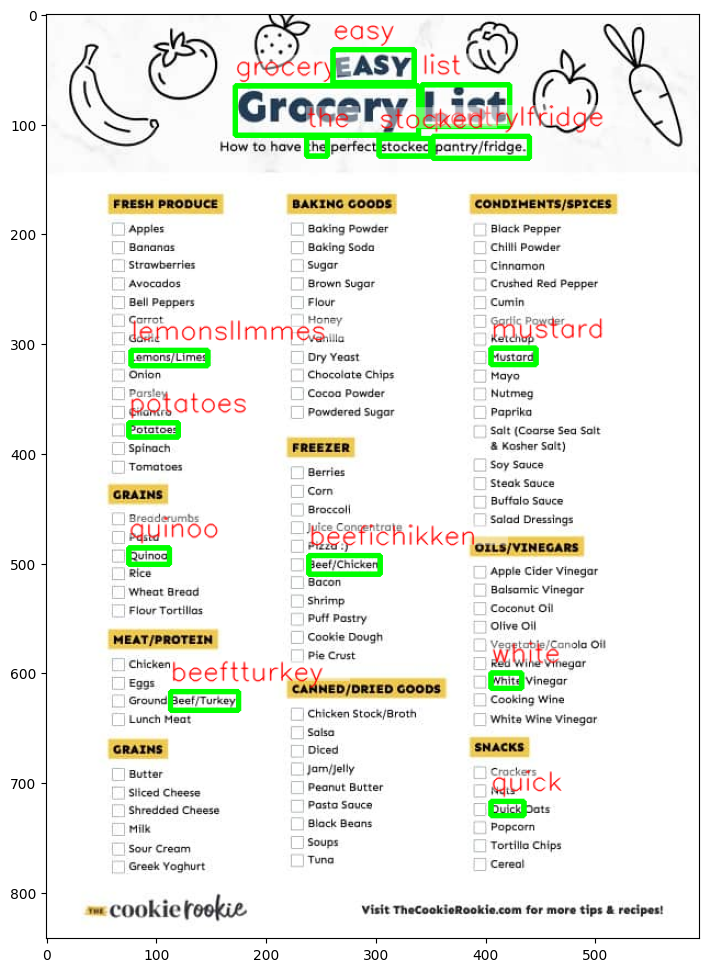

In [172]:
plt.figure(figsize=(12, 12))
plt.imshow(convert_result_to_image(image, resized_image, boxes_with_annotations, conf_labels=True));

### Show the OCR Result per Bounding Box
[back to top ⬆️](#Table-of-contents:)

Depending on the image, the OCR result may not be readable in the image with boxes, as displayed in the cell above. Use the code below to display the extracted boxes and the OCR result per box.

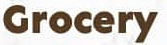

grocery

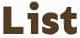

list

pantrylfridge

lemonsllmmes

beefichikken

beeftturkey

easy

mustard

stocked

quinoo

the

quick

potatoes

white

vinegar

mayo

dressings

sodo

buffalo

perfect

meatiprotein

cumin

ground

shrimp

olive

postry

goods

brown

crushed

sugar

coconut

salty

peonut

baking

nutmeg

butter

roghurt

popcarn

stockbrrtt

cooking

In [173]:
for cropped_image, annotation in zip(cropped_images, annotations):
    display(cropped_image, Markdown("".join(annotation)))

### Print Annotations in Plain Text Format
[back to top ⬆️](#Table-of-contents:)

Print annotations for detected text based on their position in the input image, starting from the upper left corner.


In [174]:
[annotation for _, annotation in sorted(zip(boxes, annotations), key=lambda x: x[0][0] ** 2 + x[0][1] ** 2)]

['grocery',
 'lemonsllmmes',
 'the',
 'easy',
 'perfect',
 'potatoes',
 'baking',
 'brown',
 'sodo',
 'stocked',
 'sugar',
 'list',
 'quinoo',
 'pantrylfridge',
 'meatiprotein',
 'beefichikken',
 'crushed',
 'shrimp',
 'cumin',
 'ground',
 'beeftturkey',
 'mustard',
 'postry',
 'mayo',
 'nutmeg',
 'buffalo',
 'stockbrrtt',
 'salty',
 'goods',
 'dressings',
 'peonut',
 'coconut',
 'roghurt',
 'olive',
 'butter',
 'white',
 'cooking',
 'vinegar',
 'quick',
 'popcarn']

In [154]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful